In [2]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
pipe = pipeline(model="facebook/bart-large-mnli")
outputs = pipe('пожелать',
    candidate_labels=['Подарок', 'Пожелание'],
)
outputs

Device set to use mps:0


In [ ]:
outputs['labels'][0]

'Пожелание'

In [ ]:
pipe('подготовить сюрприз родителям',
    candidate_labels=['подарок', 'желание'],
)

{'sequence': 'подготовить сюрприз родителям',
 'labels': ['подарок', 'желание'],
 'scores': [0.663544237613678, 0.3364557921886444]}

In [ ]:
model_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


def predict_zero_shot(text, label_texts, model, tokenizer, label='entailment', normalize=True):
    tokens = tokenizer([text] * len(label_texts), label_texts, truncation=True, return_tensors='pt', padding=True)
    with torch.inference_mode():
        result = torch.softmax(model(**tokens.to(model.device)).logits, -1)
    proba = result[:, model.config.label2id[label]].cpu().numpy()
    if normalize:
        proba /= sum(proba)
    return proba

classes = ['подарок', 'желание']
predict_zero_shot('подготовить сюрприз родителям', classes, model, tokenizer)

array([0.37635893, 0.6236411 ], dtype=float32)

In [ ]:
import yaml

with open('/Users/timmiakov/Code/AI-telegram-bot/src/config/bot_config.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.Loader)

In [ ]:
data

{'classifier_model': {'model_name': 'facebook/bart-large-mnli',
  'message_types': ['Подарок', 'Желание']}}

In [ ]:
from transformers import pipeline

messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model="MTSAIR/Cotype-Nano")
pipe(messages)

/Users/timmiakov/Code/AI-telegram-bot/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Device set to use mps:0


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'},
   {'role': 'assistant',
    'content': 'I am an AI language model developed by OpenAI. My purpose is to assist users like you by'}]}]

In [3]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
prompt = "Новогодний подарок"
image = pipe(prompt, num_inference_steps=5, height=240, width=240).images[0]

  0%|          | 0/5 [00:00<?, ?it/s]

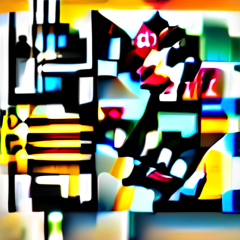

In [8]:
image

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [1]:
from diffusers import DiffusionPipeline
import torch

# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

/Users/timmiakov/Code/AI-telegram-bot/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
n_steps = 10
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
    width=240,
    height=240,
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
    width=240,
    height=240,
).images[0]


  0%|          | 0/8 [00:00<?, ?it/s]